In [1]:

import numpy as np
from matplotlib import pyplot as plt
from scipy import io
import os
import sys
from optimal_interpolation import OImerge
import calendar
import auxiliary as au
from auxiliary_merge import *

########################################################################################################################

# time periods and methods
# vars = sys.argv[1]
# vars = [vars]
# month = int(sys.argv[2])

vars = 'prcp'
vars = [vars]
month = 2

########################################################################################################################

# basic settings
weightmode = 'BMA' # method used to merge different reanalysis products
# vars = ['prcp', 'tmean', 'trange']
hwsize = 2  # 5X5 space window used to support estimation at the center grid
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)

# "Gaussian": prcp will be transformed into normal distributions; "Actual": actual space
# "Gaussian" is not a good choice because station prcp regression using box-cox has large underestimation
prcp_space = 'Actual'

### Local Mac settings
# input files/paths
path_bac = '/Users/localuser/Research/EMDNA/merge' # data that will be used as background
path_obs = '/Users/localuser/Research/EMDNA/regression' # data that will be used as observation
near_file_GMET = '/Users/localuser/Research/EMDNA/regression/weight_nearstn.npz' # near station of stations/grids
file_mask = './DEM/NA_DEM_010deg_trim.mat'
FileStnInfo = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt'
gmet_stndatafile = '/Users/localuser/Research/EMDNA/stndata_whole.npz'

# output files/paths (can also be used as inputs once generated)
path_oimerge = '/Users/localuser/Research/EMDNA/oimerge'

### Local Mac settings


# ### Plato settings
# # input files/paths
# path_bac = '/datastore/GLOBALWATER/CommonData/EMDNA/ReanalysisCorrMerge/Reanalysis_merge'
# path_obs = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout'
# near_file_GMET = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout/weight.npz'
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
# FileStnInfo = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/stnlist_whole.txt'
# gmet_stndatafile = '/datastore/GLOBALWATER/CommonData/EMDNA/stndata_whole.npz'
#
# # output files/paths (can also be used as inputs once generated)
# path_oimerge = '/home/gut428/OImerge'
# ### Plato settings

file_regression_stn = path_obs + '/daily_regression_stn.npz'
file_corrmerge_stn = [''] * len(vars)
for i in range(len(vars)):
    if vars[i] == 'pop':
        file_corrmerge_stn[i] = path_bac + '/merge_stn_' + vars[i] + '_GWR_' + weightmode + '.npz'
    else:
        file_corrmerge_stn[i] = path_bac + '/mergecorr_stn_' + vars[i] + '_GWRQM_' + weightmode + '.npz'

########################################################################################################################

# basic processing
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels
nrows, ncols = np.shape(mask)

# date
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

# stninfo
stnID, stninfo = au.readstnlist(FileStnInfo)
nstn = len(stnID)

/Users/localuser/Github/PyGMET/auxiliary.py:13: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(FileStnInfo, delimiter=',', dtype=None, skip_header=2)


In [3]:
for v in range(len(vars)):
    print('OI merge at stations:', vars[v])
    filemerge_stn = path_oimerge + '/OImerge_stn_GWRQMBMA_' + vars[v] + '.npz'
#     if os.path.isfile(filemerge_stn):
#         continue

    # load station original observations
    datatemp = np.load(gmet_stndatafile)
    if vars[v] == 'pop':
        observation_stn = datatemp['prcp_stn']
        observation_stn[observation_stn > 0] = 1
    else:
        observation_stn = datatemp[vars[v]+'_stn']

    # load station regression estimates (obs)
    datatemp = np.load(file_regression_stn)
    regression_stn = datatemp[vars[v]]
    del datatemp

    # load corrected/merged reanalysis data at all station points (those are totally independent with station observations)
    datatemp = np.load(file_corrmerge_stn[v])
    reafinal_stn = datatemp['reamerge_stn']
    nstn, ntimes = np.shape(reafinal_stn)
    del datatemp

    # load near station information
    datatemp = np.load(near_file_GMET)
    if vars[v] == 'prcp' or vars[v] == 'pop':
        near_loc = datatemp['near_stn_prcpLoc']
        near_weight = datatemp['near_stn_prcpWeight']
    else:
        near_loc = datatemp['near_stn_tempLoc']
        near_weight = datatemp['near_stn_tempWeight']
    del datatemp


OI merge at stations: prcp


In [4]:
    oimerge_stn = np.nan * np.zeros([nstn, ntimes], dtype=np.float32)
    for m in range(1):
        print('month', m + 1)
        indm = (date_number['mm'] == m + 1)
        nday = sum(indm)

        filemerge_stnm = path_oimerge + '/OImerge_stn_GWRQMBMA_' + vars[v] + '_' + str(m+1) + '--.npz'
        if not os.path.isfile(filemerge_stnm):
            # use optimal interpolation to get OI-merged estimate at each station points
            for i in range(26502,26502+1):
                if np.mod(i,100)==0:
                    print('station',i,nstn)
                if np.isnan(observation_stn[i, 0]):
                    continue

                near_loci = near_loc[i, :]
                near_loci = near_loci[near_loci > -1]

                b_tar = reafinal_stn[i, indm]
                o_tar = regression_stn[i, indm]
                b_near = reafinal_stn[near_loci,:][:, indm]
                o_near = regression_stn[near_loci,:][:, indm]

                tar_err_b = b_tar - observation_stn[i, indm]
                near_err_b = b_near - observation_stn[near_loci,:][:, indm]
                near_err_o = o_near - observation_stn[near_loci,:][:, indm]

                # delete possible nan values
                indnan = ~np.isnan(tar_err_b + np.sum(near_err_b,axis=0) + np.sum(near_err_o,axis=0) )
                weight = OImerge(tar_err_b[indnan], near_err_b[:, indnan], near_err_o[:, indnan], eye_o=0)
                if np.any(np.isnan(weight)) or np.any(abs(weight) > 2):
                    weight = near_weight[i, 0:len(near_loci)]
                    weight = weight / np.sum(weight)

                diff = o_near - b_near
                merge_est = b_tar.copy()
                for id in range(nday):
                    merge_est[id] = merge_est[id] + np.dot(weight, diff[:, id])
                oimerge_stn[i, indm] = merge_est

month 1


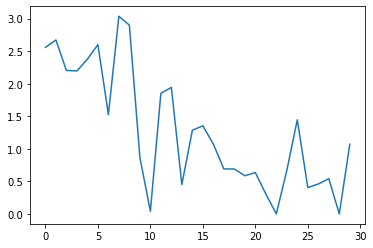

In [30]:
plt.plot(o_near[:,1])

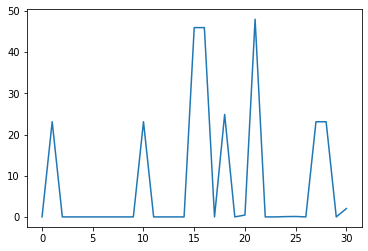

In [28]:
plt.plot(o_tar[0:31])

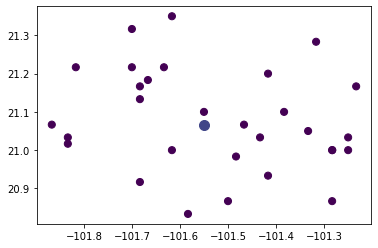

In [39]:
plt.scatter(stninfo[near_loci,2],stninfo[near_loci,1],50,observation_stn[near_loci, 9])
plt.clim([0,10])
plt.scatter(stninfo[26502,2],stninfo[26502,1],100,observation_stn[i, 9])
plt.clim([0,10])

In [43]:
stnID[26502]

'GS76575299999'

In [41]:
near_loci

array([ 3849,  3858,  3850, 26504, 26942,  3810,  3834,  3772,  3757,
        3777,  3780,  3799,  3769,  3829,  3761,  3788,  3837, 26503,
        2845,  3855,  3760,  3814, 26964,  3809,  3823,  4200,  3786,
        3796,  3840,  3836])